In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import transforms
from miniai.imports import *
from miniai.datasets import *
from datasets import load_dataset

/home/galvanized_heart/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Get Tiny Imagenet Data

In [2]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name).remove_columns(yl)

### Test Collate Function

In [27]:
class TestModel(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.layer = nn.Linear(inp, out)
        
    def forward(self, x):
        print(f"x before layer: {x.shape}")
        x = self.layer(x)
        print(f"x after layer: {x.shape}")
        return x

In [61]:
# From ../03_collate_CLIP_verification.ipynb
@inplace
def transformi(b): 
    b[xl] = [TF.to_tensor(o) for o in b[xl]]

def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

def noisify(x0):
    device = x0.device
    x = clip_pro(images=x0, return_tensors="pt", do_rescale=False).to(device)
    c = clip_model.get_image_features(x["pixel_values"])
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device), c), ε

"""def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε"""

def collate_sd(b): return noisify(default_collate(b)[xl])

def dl_sd(ds): 
    return DataLoader(ds, batch_size=16, collate_fn=collate_sd, num_workers=0)

tdsd = dsd.with_transform(transformi)
dls = DataLoaders(dl_sd(tdsd['train']), dl_sd(tdsd['valid']))

In [21]:
dl = dls.train
b = next(iter(dl))
b.shape

torch.Size([16, 3, 64, 64])

In [31]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = TestModel(64,64)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

x before layer: torch.Size([3, 64, 64])
x after layer: torch.Size([3, 64, 64])


TypeError: 'NoneType' object is not callable

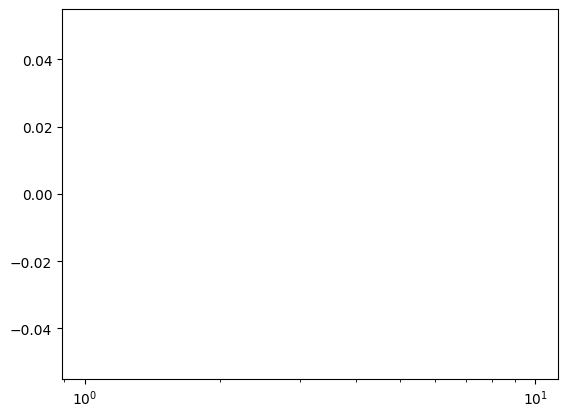

In [32]:
learn.lr_find()

In [62]:
clip_pro = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

def noisify(x0):
    device = x0.device
    x = clip_pro(images=x0, return_tensors="pt", do_rescale=False).to(device)
    c = clip_model.get_image_features(x["pixel_values"])
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device), c), ε

x = torch.randn(16, 3, 64, 64).to("cuda")
x.shape

In [57]:
n_b = noisify(b.to("cuda"))
n_b

((tensor([[[[ 8.4731e-02,  1.9793e+00,  9.7886e-01,  ...,  1.0126e+00,
              6.7303e-01,  7.7479e-01],
            [-8.9636e-03,  8.2476e-01,  2.0018e-01,  ...,  4.4483e-01,
              7.5774e-01,  8.2832e-02],
            [ 4.4587e-01,  1.5716e+00,  1.1063e+00,  ...,  7.2791e-01,
              1.0862e+00, -1.3420e-02],
            ...,
            [ 7.9089e-01, -4.1945e-01,  2.3909e-01,  ..., -5.2777e-02,
              5.1529e-01, -8.6123e-02],
            [ 4.7922e-01,  2.7403e-02,  4.0663e-01,  ...,  1.9648e-01,
              8.9855e-01,  2.1424e-02],
            [-9.1558e-03,  4.3567e-01,  1.7748e-01,  ..., -5.4675e-01,
             -3.1867e-01, -4.8917e-01]],
  
           [[-2.7990e-01,  7.8568e-01, -5.2200e-01,  ..., -2.0675e-01,
              8.0967e-01,  1.0832e-01],
            [ 9.1428e-01,  5.9087e-01,  1.5969e+00,  ...,  3.4134e-01,
              2.1094e-01,  6.5804e-02],
            [-5.0594e-01,  6.2912e-01,  6.7839e-01,  ...,  1.2645e+00,
              6.6357

In [59]:
type(n_b[0]), len(n_b[0])

(tuple, 3)

In [60]:
n_b[0][0].shape,n_b[0][1].shape,n_b[0][2].shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]), torch.Size([16, 768]))

In [47]:
n = len(x)
n

16

In [38]:
t = torch.rand(n,).to(x).clamp(0,0.999)
t.shape

torch.Size([16])

In [39]:
eps = torch.randn(x.shape)
eps.shape

torch.Size([16, 3, 64, 64])

In [40]:
abar_t = abar(t)
print(abar_t.shape)
abar_t = abar_t.reshape(-1,1,1,1)
abar_t.shape

torch.Size([16])


torch.Size([16, 1, 1, 1])

In [41]:
xt = abar_t.sqrt()*x + (1-abar_t).sqrt()*eps
xt.shape

torch.Size([16, 3, 64, 64])

### Test Collate Function

In [3]:
# Required functions for loading pickled DataLoaders
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

def transform(batch):
    print("Transforming batch")
    transformed = [TF.to_tensor(o) for o in batch[xl]] # This gives "TypeError: only integer tensors of a single element can be converted to an index"
    print("Finished transforming")
    return transformed

def abar(t): 
    return (t*math.pi/2).cos()**2

def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    eps = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*eps
    return (xt, t.to(device)), eps

def collate_clip(batch):
    print("Collate clip")
    batch = default_collate(batch)
    print("After default")
    batch = batch["image"]
    print(batch)
    print(type(batch))
    print(len(batch))
    return
    with torch.no_grad():
        inputs = processor(images=batch["image"], return_tensors="pt", do_rescale=False)
        print("After CLIP processing")
        image_input = inputs["pixel_values"]
        image_features = model.get_image_features(image_input)
    print("After CLIP embs")
    (xt, t), eps = noisify(batch)
    print("After noisify")
    return (xt, t, image_features), eps

def dl_ddpm(ds): 
    return DataLoader(ds, batch_size=16, collate_fn=collate_clip, num_workers=0)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

def PIL_to_tensor(batch):
    print(batch)
    batch["image"] = [transform(image) for image in batch["image"]]
    print(batch)
    return batch

tdsd = dsd.map(PIL_to_tensor, batched=True)

In [ ]:
dls = DataLoaders(dl_ddpm(tdsd['train']), dl_ddpm(tdsd['valid']))

In [ ]:
dl = dls.train
b = next(iter(dl))
b

Collate clip
After default


ValueError: only one element tensors can be converted to Python scalars